In [12]:
# Import libraries
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import helper
from itertools import product

In [13]:
# Load retention time data
tdata = pd.read_csv("../data/retention/retention.min.csv.gz")

# Time point
timept = 10000

# Max
MAX = 58

In [14]:
# Get PBA allocations
pba_allocations_bpc = {1: set(), 2: set()}
for gamma in np.arange(0, 0.0061, 0.0002):
    print("gamma =", gamma)
    lvlcands = {}
    for (lower, upper), d in tdata[(tdata["timept"] == timept) & (tdata["lower"] <= MAX)].groupby(["lower","upper"]):
        lvlcand = d.mean()[["timept","lower","upper","width","successes","failures","reads","sets","resets","cycles","read_bits","set_bits","reset_bits","lvl","time"]].to_dict()
        lvl, cdf = sorted(d["lvl"].values), np.linspace(0.5/len(d), 1-0.5/len(d), len(d)) # symmetric percentile CDF (https://math.stackexchange.com/questions/33488/how-to-calculate-percentile-is-it-possible-to-get-100-percentile)
        try:
            lvlcand["lower_rd"] = int(np.floor(helper.intersection(np.array([0,64]), np.array([gamma,gamma]), np.array(lvl), cdf)[0][0]))
            lvlcand["upper_rd"] = int(np.ceil(helper.intersection(np.array([0,64]), np.array([1-gamma,1-gamma]), np.array(lvl), cdf)[0][0]))
            lvlcands[(int(lower), int(upper))] = lvlcand
        except IndexError:
            continue

    pba_allocations = []
    cur_upper = -1
    while True:
        cands = [lvlcand for lvlcand in lvlcands.values() if lvlcand["lower_rd"] > cur_upper]
        if cands == []:
            break
        next_cur_upper = min([cand["upper_rd"] for cand in cands])
        pba_allocations.append([(int(cand["lower"]), int(cand["upper"])) for cand in cands if cand["upper_rd"] == next_cur_upper])
        cur_upper = next_cur_upper
    print(pba_allocations)
    if len(pba_allocations) >= 2:
        pba_allocations_bpc[1].update(product(*pba_allocations[:2]))
    if len(pba_allocations) >= 4:
        pba_allocations_bpc[2].update(product(*pba_allocations[:4]))
pba_allocations_bpc

gamma = 0.0
[]
gamma = 0.0002
[]
gamma = 0.0004
[[(1, 7)], [(36, 40), (38, 40)], [(56, 58)]]
gamma = 0.0006000000000000001
[[(1, 7)], [(36, 40), (38, 40)], [(56, 58)]]
gamma = 0.0008
[[(1, 7)], [(36, 40), (37, 41), (38, 40)], [(55, 57), (56, 58)]]
gamma = 0.001
[[(1, 7)], [(36, 40), (37, 41), (38, 40)], [(55, 57), (56, 58)]]
gamma = 0.0012000000000000001
[[(1, 7)], [(31, 42), (32, 38), (32, 40), (32, 41), (34, 37), (34, 40), (36, 38)], [(52, 56), (52, 57), (53, 56), (53, 57), (54, 56), (55, 57)]]
gamma = 0.0014
[[(1, 7)], [(31, 42), (32, 38), (32, 40), (32, 41), (34, 37), (34, 40), (36, 38)], [(52, 56), (52, 57), (53, 56), (53, 57), (54, 56), (55, 57)]]
gamma = 0.0016
[[(1, 7)], [(31, 42), (32, 38), (32, 40), (32, 41), (34, 37), (34, 40), (36, 38)], [(52, 56), (52, 57), (53, 56), (53, 57), (54, 56), (55, 57)]]
gamma = 0.0018000000000000002
[[(1, 7)], [(31, 42), (32, 38), (32, 40), (32, 41), (34, 37), (34, 40), (36, 38)], [(52, 56), (52, 57), (53, 56), (53, 57), (54, 56), (55, 57)]]
gam

{1: {((0, 7), (27, 37)),
  ((0, 7), (28, 36)),
  ((0, 7), (29, 35)),
  ((0, 7), (32, 34)),
  ((0, 7), (32, 35)),
  ((1, 7), (31, 42)),
  ((1, 7), (32, 35)),
  ((1, 7), (32, 38)),
  ((1, 7), (32, 40)),
  ((1, 7), (32, 41)),
  ((1, 7), (34, 37)),
  ((1, 7), (34, 40)),
  ((1, 7), (36, 38)),
  ((1, 7), (36, 40)),
  ((1, 7), (37, 41)),
  ((1, 7), (38, 40)),
  ((2, 7), (27, 37)),
  ((2, 7), (28, 36)),
  ((2, 7), (29, 35)),
  ((2, 7), (32, 34)),
  ((2, 7), (32, 35)),
  ((3, 7), (27, 37)),
  ((3, 7), (28, 36)),
  ((3, 7), (29, 35)),
  ((3, 7), (32, 34)),
  ((3, 7), (32, 35))},
 2: {((0, 7), (27, 37), (49, 51), (58, 60)),
  ((0, 7), (27, 37), (49, 51), (58, 61)),
  ((0, 7), (28, 36), (49, 51), (58, 60)),
  ((0, 7), (28, 36), (49, 51), (58, 61)),
  ((0, 7), (29, 35), (49, 51), (58, 60)),
  ((0, 7), (29, 35), (49, 51), (58, 61)),
  ((0, 7), (32, 34), (49, 51), (58, 60)),
  ((0, 7), (32, 34), (49, 51), (58, 61)),
  ((0, 7), (32, 34), (49, 51), (58, 62)),
  ((0, 7), (32, 35), (49, 51), (58, 60)),
 

In [15]:
# Digraph
DG = nx.DiGraph()
DG.add_nodes_from(lvlcands.items())
DG.add_edges_from([(cand1, cand2) for cand1 in lvlcands for cand2 in lvlcands if lvlcands[cand2]["lower_rd"] > lvlcands[cand1]["upper_rd"]])
DG.number_of_nodes(), DG.number_of_edges()

(2006, 280540)

In [16]:
# Get all possible level allocations
allocations = []
for root in [(i,j) for i in range(1) for j in range(64)]:
  for leaf in [(k,l) for k in range(root[1],MAX) for l in range(MAX,64)]:
    print("ROOT", root, "LEAF", leaf)
    try:
      for path in nx.all_simple_paths(DG, root, leaf):
        allocations.append(tuple(path))  
    except nx.NodeNotFound:
       pass
len(allocations)

ROOT (0, 0) LEAF (0, 58)
ROOT (0, 0) LEAF (0, 59)
ROOT (0, 0) LEAF (0, 60)
ROOT (0, 0) LEAF (0, 61)
ROOT (0, 0) LEAF (0, 62)
ROOT (0, 0) LEAF (0, 63)
ROOT (0, 0) LEAF (1, 58)
ROOT (0, 0) LEAF (1, 59)
ROOT (0, 0) LEAF (1, 60)
ROOT (0, 0) LEAF (1, 61)
ROOT (0, 0) LEAF (1, 62)
ROOT (0, 0) LEAF (1, 63)
ROOT (0, 0) LEAF (2, 58)
ROOT (0, 0) LEAF (2, 59)
ROOT (0, 0) LEAF (2, 60)
ROOT (0, 0) LEAF (2, 61)
ROOT (0, 0) LEAF (2, 62)
ROOT (0, 0) LEAF (2, 63)
ROOT (0, 0) LEAF (3, 58)
ROOT (0, 0) LEAF (3, 59)
ROOT (0, 0) LEAF (3, 60)
ROOT (0, 0) LEAF (3, 61)
ROOT (0, 0) LEAF (3, 62)
ROOT (0, 0) LEAF (3, 63)
ROOT (0, 0) LEAF (4, 58)
ROOT (0, 0) LEAF (4, 59)
ROOT (0, 0) LEAF (4, 60)
ROOT (0, 0) LEAF (4, 61)
ROOT (0, 0) LEAF (4, 62)
ROOT (0, 0) LEAF (4, 63)
ROOT (0, 0) LEAF (5, 58)
ROOT (0, 0) LEAF (5, 59)
ROOT (0, 0) LEAF (5, 60)
ROOT (0, 0) LEAF (5, 61)
ROOT (0, 0) LEAF (5, 62)
ROOT (0, 0) LEAF (5, 63)
ROOT (0, 0) LEAF (6, 58)
ROOT (0, 0) LEAF (6, 59)
ROOT (0, 0) LEAF (6, 60)
ROOT (0, 0) LEAF (6, 61)


54839

In [17]:
# Get all 1-2 bpc allocations
allocations_bpc = {1 : [a for a in allocations if len(a) == 2], 2 : [a for a in allocations if len(a) == 4]}
{k : len(v) for k, v in allocations_bpc.items()}

{1: 5528, 2: 23}

In [18]:
# Plot BW-BER tradeoff in level allocations
results = []
for bpc in range(1, 3):
    for i, a in enumerate(allocations_bpc[bpc] + list(pba_allocations_bpc[bpc])):
        if i % 10 == 0:
            print(bpc, i)

        rdbounds = [0]
        for lvl1, lvl2 in zip(a[:-1], a[1:]):
            rdbounds.append(int((lvlcands[lvl1]["upper_rd"] + lvlcands[lvl2]["lower_rd"]) // 2))
        rdbounds.append(64)

        times, confmat = [], []
        for i, lvl in enumerate(a):
            # Get the relevant data
            lvldata = tdata[(tdata["timept"] == timept) & (tdata["lower"] == lvl[0]) & (tdata["upper"] == lvl[1])]

            # Compute average time to target level
            times.append(lvldata["cycles"].mean() * 10e-9)

            # Compute the CER for level
            confvec = []
            for rdbound_low, rdbound_high in zip(rdbounds[:-1], rdbounds[1:]):
                confvec.append(lvldata[(lvldata["lvl"] > rdbound_low) & (lvldata["lvl"] <= rdbound_high)].count()[0])
            confmat.append(confvec)
        times, confmat = np.array(times), np.array(confmat)
        
        # Compute overall results
        bw = (48 - np.genfromtxt("../settings/dead_columns.csv", delimiter=",").size) / times.mean() * bpc

        # Symbol error magnitudes
        mae = sum(abs(i - j) * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum()
        rmse = np.sqrt(sum((i - j)**2 * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum())

        # Function to get Gray code string
        getgray = lambda x : format(2**(2**bpc) + x^x//2, f"0{2**bpc-1}b")[1:]

        # Function to get Gray code error rate for each possible symbol confusion
        grayerr = np.array([[sum([int(ic != jc) for ic, jc in zip(getgray(i), getgray(j))]) for i in range(2**bpc)] for j in range(2**bpc)]) / bpc

        # BER
        ber = (grayerr * confmat).sum() / confmat.sum()

        # CER
        cer = 1 - confmat.trace() / confmat.sum()

        # Is a PBA allocation
        is_pba = a in pba_allocations_bpc[bpc]

        # Results
        results.append([bpc, a, rdbounds, confmat, bw, ber, cer, is_pba])

# Get dataframe
data = pd.DataFrame(results, columns=["bpc", "allocation", "read_bounds", "confmat", "bw", "ber", "cer", "is_pba"]).sort_values(["ber", "bw"], ascending=[True, False])
data.to_csv("../data/allocation/allocations.csv", index=False)
data

1 0
1 10
1 20
1 30
1 40
1 50
1 60
1 70
1 80
1 90
1 100
1 110
1 120
1 130
1 140
1 150
1 160
1 170
1 180
1 190
1 200
1 210
1 220
1 230
1 240
1 250
1 260
1 270
1 280
1 290
1 300
1 310
1 320
1 330
1 340
1 350
1 360
1 370
1 380
1 390
1 400
1 410
1 420
1 430
1 440
1 450
1 460
1 470
1 480
1 490
1 500
1 510
1 520
1 530
1 540
1 550
1 560
1 570
1 580
1 590
1 600
1 610
1 620
1 630
1 640
1 650
1 660
1 670
1 680
1 690
1 700
1 710
1 720
1 730
1 740
1 750
1 760
1 770
1 780
1 790
1 800
1 810
1 820
1 830
1 840
1 850
1 860
1 870
1 880
1 890
1 900
1 910
1 920
1 930
1 940
1 950
1 960
1 970
1 980
1 990
1 1000
1 1010
1 1020
1 1030
1 1040
1 1050
1 1060
1 1070
1 1080
1 1090
1 1100
1 1110
1 1120
1 1130
1 1140
1 1150
1 1160
1 1170
1 1180
1 1190
1 1200
1 1210
1 1220
1 1230
1 1240
1 1250
1 1260
1 1270
1 1280
1 1290
1 1300
1 1310
1 1320
1 1330
1 1340
1 1350
1 1360
1 1370
1 1380
1 1390
1 1400
1 1410
1 1420
1 1430
1 1440
1 1450
1 1460
1 1470
1 1480
1 1490
1 1500
1 1510
1 1520
1 1530
1 1540
1 1550
1 1560
1 1570
1 158

,bpc,allocation,read_bounds,confmat,bw,ber,cer,is_pba
2654,1,"((0, 24), (25, 63))","[0, 24, 64]","[[1386, 0], [0, 1344]]",2.450989e+07,0.000000,0.000000,False
2661,1,"((0, 24), (32, 63))","[0, 25, 64]","[[1386, 0], [0, 1344]]",2.450989e+07,0.000000,0.000000,False
3031,1,"((0, 27), (32, 63))","[0, 25, 64]","[[1386, 0], [0, 1344]]",2.450989e+07,0.000000,0.000000,False
3387,1,"((0, 30), (32, 63))","[0, 25, 64]","[[1386, 0], [0, 1344]]",2.450989e+07,0.000000,0.000000,False
2787,1,"((0, 25), (32, 63))","[0, 25, 64]","[[1386, 0], [0, 1344]]",2.445368e+07,0.000000,0.000000,False
...,...,...,...,...,...,...,...,...
116,1,"((0, 5), (27, 63))","[0, 27, 64]","[[1378, 8], [7, 1337]]",8.116591e+04,0.005495,0.005495,False
21,1,"((0, 2), (42, 62))","[0, 27, 64]","[[1378, 8], [7, 1337]]",8.084485e+04,0.005495,0.005495,False
132,1,"((0, 5), (42, 62))","[0, 27, 64]","[[1378, 8], [7, 1337]]",8.084485e+04,0.005495,0.005495,False
20,1,"((0, 2), (42, 60))","[0, 27, 64]","[[1378, 8], [7, 1337]]",8.080266e+04,0.005495,0.005495,False


In [26]:
# Load allocations
data = pd.read_csv("../data/allocation/allocations.csv", converters={"allocation": eval, "read_bounds": eval}).drop(columns="confmat")
data

,bpc,allocation,read_bounds,bw,ber,cer,is_pba
0,1,"((0, 24), (25, 63))","[0, 24, 64]",2.450989e+07,0.000000,0.000000,False
1,1,"((0, 24), (32, 63))","[0, 25, 64]",2.450989e+07,0.000000,0.000000,False
2,1,"((0, 27), (32, 63))","[0, 25, 64]",2.450989e+07,0.000000,0.000000,False
3,1,"((0, 30), (32, 63))","[0, 25, 64]",2.450989e+07,0.000000,0.000000,False
4,1,"((0, 25), (32, 63))","[0, 25, 64]",2.445368e+07,0.000000,0.000000,False
...,...,...,...,...,...,...,...
5609,1,"((0, 5), (27, 63))","[0, 27, 64]",8.116591e+04,0.005495,0.005495,False
5610,1,"((0, 2), (42, 62))","[0, 27, 64]",8.084485e+04,0.005495,0.005495,False
5611,1,"((0, 5), (42, 62))","[0, 27, 64]",8.084485e+04,0.005495,0.005495,False
5612,1,"((0, 2), (42, 60))","[0, 27, 64]",8.080266e+04,0.005495,0.005495,False


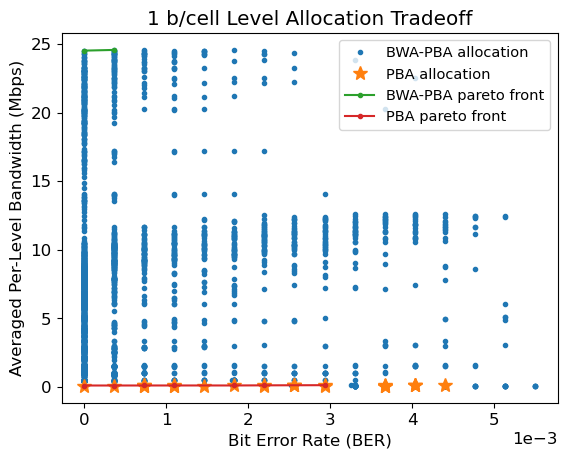

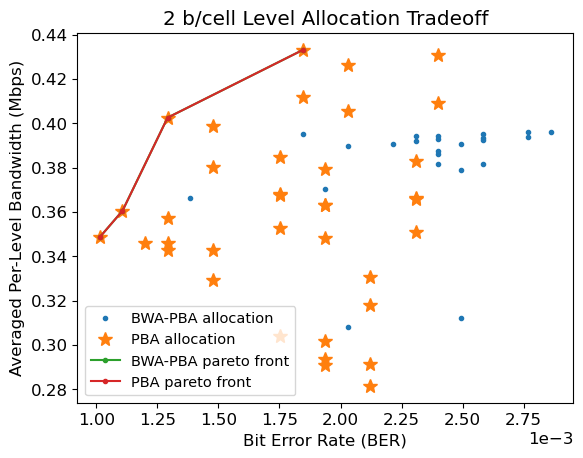

,bpc,allocation,read_bounds,bw,ber,cer,is_pba,bacc
0,1,"((0, 24), (25, 63))","[0, 24, 64]",2.450989e+07,0.000000,0.000000,False,1.000000
3363,1,"((0, 24), (26, 63))","[0, 25, 64]",2.456140e+07,0.000366,0.000366,False,0.999634
3362,1,"((1, 7), (36, 40))","[0, 15, 64]",1.048883e+05,0.000000,0.000000,True,1.000000
4472,2,"((1, 7), (32, 35), (49, 51), (58, 62))","[0, 12, 37, 51, 64]",3.487390e+05,0.001015,0.002030,True,0.998985
4631,2,"((0, 7), (32, 35), (49, 51), (58, 62))","[0, 12, 37, 51, 64]",3.605457e+05,0.001107,0.002215,True,0.998893
4633,2,"((3, 7), (32, 35), (49, 51), (58, 62))","[0, 12, 37, 51, 64]",4.025542e+05,0.001292,0.002584,True,0.998708
4885,2,"((3, 7), (27, 37), (49, 51), (58, 61))","[0, 11, 37, 52, 64]",4.331045e+05,0.001846,0.003691,True,0.998154


In [27]:
# Pareto curve
data["bacc"] = 1 - data["ber"]
best = []
for bpc in range(1, 3):
    data_bpc = data[data["bpc"] == bpc].drop_duplicates(subset=["allocation"])
    data_bpc = data_bpc.drop_duplicates(subset=["ber", "bw"])

    plt.plot(data_bpc["ber"], data_bpc["bw"] / 1e6, ".", label="BWA-PBA allocation")
    plt.plot(data_bpc[data_bpc["is_pba"]]["ber"], data_bpc[data_bpc["is_pba"]]["bw"] / 1e6, "*", markersize=10, label="PBA allocation")

    costs = data_bpc[["bacc", "bw"]].values
    unique_costs = data_bpc[["bacc", "bw"]].drop_duplicates().values #
    is_pareto = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        is_pareto[i] = np.all(np.any(np.delete(costs,i,axis=0)<c, axis=1))
    best.append(data_bpc[is_pareto])
    plt.plot(data_bpc[is_pareto]["ber"], data_bpc[is_pareto]["bw"] / 1e6, '.-', label="BWA-PBA pareto front")
    
    pba_data_bpc = data_bpc[data_bpc["is_pba"]]
    pba_costs = pba_data_bpc[["bacc", "bw"]].values
    pba_is_pareto = np.ones(pba_data_bpc.shape[0], dtype = bool)
    for i, c in enumerate(pba_costs):
        pba_is_pareto[i] = np.all(np.any(np.delete(pba_costs,i,axis=0)<c, axis=1))
    best.append(pba_data_bpc[pba_is_pareto & (pba_data_bpc["ber"] == 0)])
    plt.plot(pba_data_bpc[pba_is_pareto]["ber"], pba_data_bpc[pba_is_pareto]["bw"] / 1e6, '.-', label="PBA pareto front")
    
    plt.ticklabel_format(style="sci", axis="x", scilimits=(0,0))
    plt.title(f"{bpc} b/cell Level Allocation Tradeoff")
    plt.xlabel("Bit Error Rate (BER)")
    plt.ylabel("Averaged Per-Level Bandwidth (Mbps)")
    plt.legend(fontsize=10.5)
    plt.show()
best = pd.concat(best).drop_duplicates(subset=["allocation"])
best

bpc                              1
allocation     ((0, 24), (25, 63))
read_bounds            [0, 24, 64]
bw                 24509893.316313
ber                            0.0
cer                            0.0
is_pba                       False
bacc                           1.0
Name: 0, dtype: object


/home/ember/anaconda3/lib/python3.9/site-packages/matplotlib/transforms.py:2665: RuntimeWarning: invalid value encountered in double_scalars
  [0.0    , y_scale, (-inb*y_scale)],


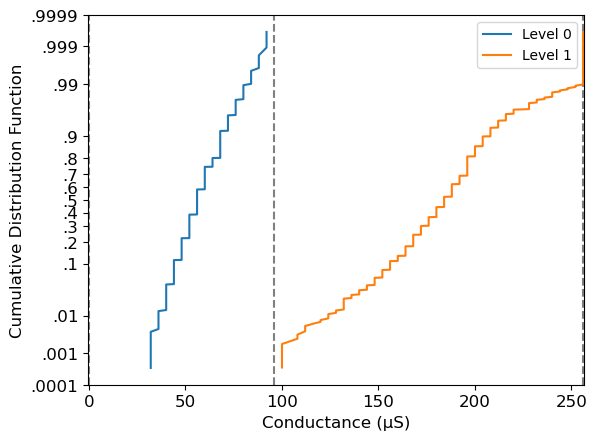

bpc                              1
allocation     ((0, 24), (26, 63))
read_bounds            [0, 25, 64]
bw                 24561403.508772
ber                       0.000366
cer                       0.000366
is_pba                       False
bacc                      0.999634
Name: 3363, dtype: object


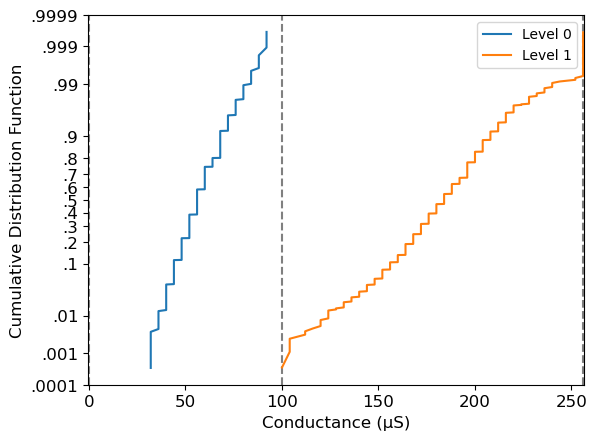

bpc                             1
allocation     ((1, 7), (36, 40))
read_bounds           [0, 15, 64]
bw                  104888.327702
ber                           0.0
cer                           0.0
is_pba                       True
bacc                          1.0
Name: 3362, dtype: object


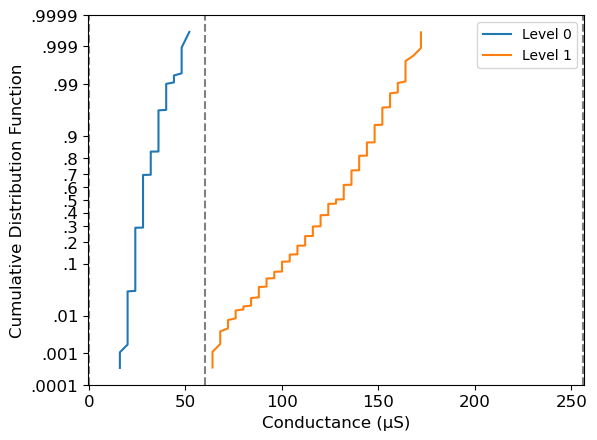

bpc                                                 2
allocation     ((1, 7), (32, 35), (49, 51), (58, 62))
read_bounds                       [0, 12, 37, 51, 64]
bw                                      348739.047724
ber                                          0.001015
cer                                           0.00203
is_pba                                           True
bacc                                         0.998985
Name: 4472, dtype: object


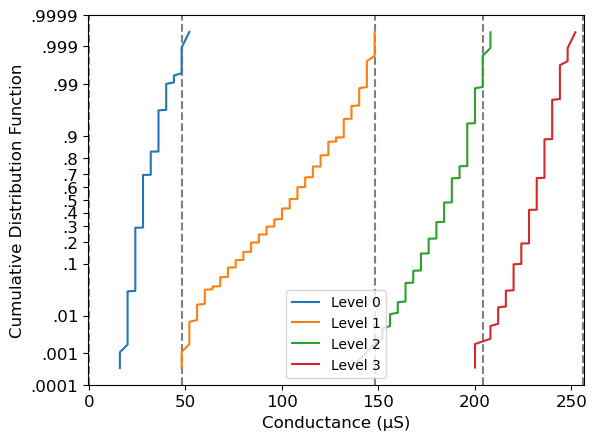

bpc                                                 2
allocation     ((0, 7), (32, 35), (49, 51), (58, 62))
read_bounds                       [0, 12, 37, 51, 64]
bw                                      360545.654535
ber                                          0.001107
cer                                          0.002215
is_pba                                           True
bacc                                         0.998893
Name: 4631, dtype: object


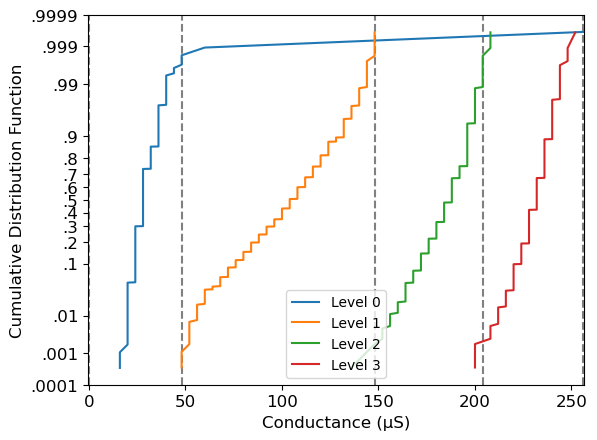

bpc                                                 2
allocation     ((3, 7), (32, 35), (49, 51), (58, 62))
read_bounds                       [0, 12, 37, 51, 64]
bw                                      402554.202421
ber                                          0.001292
cer                                          0.002584
is_pba                                           True
bacc                                         0.998708
Name: 4633, dtype: object


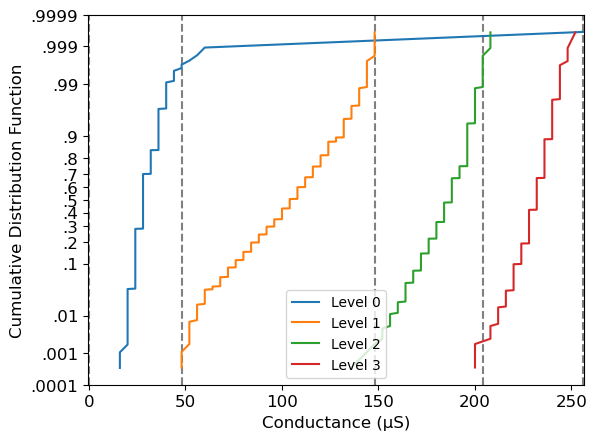

bpc                                                 2
allocation     ((3, 7), (27, 37), (49, 51), (58, 61))
read_bounds                       [0, 11, 37, 52, 64]
bw                                      433104.513184
ber                                          0.001846
cer                                          0.003691
is_pba                                           True
bacc                                         0.998154
Name: 4885, dtype: object


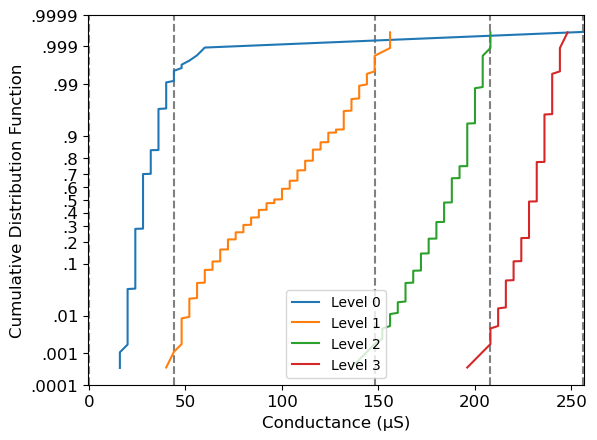

In [28]:
# Visualize allocations
for i, d in best.iterrows():
    plt.xlim(-0.5, 256.5)
    plt.gca().set_yscale("ppf")
    plt.xlabel("Conductance (µS)")
    plt.ylabel("Cumulative Distribution Function")
    print(d)
    for bound in d["read_bounds"]:
        plt.axvline(bound*4, color="gray", linestyle="--")
    for j, lvl in enumerate(d["allocation"]):
        # Get the relevant data
        lvldata = tdata[(tdata["timept"] == timept) & (tdata["lower"] == lvl[0]) & (tdata["upper"] == lvl[1])]

        # Plot distributions
        plt.plot(sorted(lvldata["lvl"].values * 4), np.linspace(0.5/len(lvldata["lvl"].values), 1-0.5/len(lvldata["lvl"].values), len(lvldata["lvl"].values)), label=f"Level {j}")
    plt.legend(fontsize=10)
    plt.show()

In [29]:
# Write out configs
import json
from copy import deepcopy
with open("../settings/config.json") as config_tmpl_file:
    config_tmpl = json.load(config_tmpl_file)

for i, d in best.iterrows():
    with open(f"../settings/opt/{d['bpc']}bpc_{'bwa' if not d['is_pba'] else 'pba'}_{i}.json", "w") as config_outfile:
        config = deepcopy(config_tmpl)
        config["num_levels"] = len(d["allocation"])
        config["level_settings"] = config["level_settings"][:config["num_levels"]]
        config["post_read_setup_cycles"] = 2 # if d["bpc"] == 1 else 16
        for lvl, ((lower_write, upper_write), read_bound) in enumerate(zip(d["allocation"], d["read_bounds"][1:])):
            config["level_settings"][lvl]["adc_lower_write_ref_lvl"] = lower_write
            config["level_settings"][lvl]["adc_upper_write_ref_lvl"] = upper_write
            config["level_settings"][lvl]["adc_upper_read_ref_lvl"] = min(read_bound, 63)
        # config["level_settings"][-1]["bl_dac_set_lvl_start"] = 20
        json.dump(config, config_outfile, indent=4)